In [13]:
import numpy as np
import matplotlib.pyplot as plt
from ase import Atoms

# Import the data, in this case an npz file 
# of a molecular dynamics trajectory for aspirin
data = np.load("../data/md17_aspirin_10000.npz")

# Coordinates for each timestep
R = data['R']
n_steps, n_atoms, _ = R.shape
print(f'Total of {R.shape[0]} steps for {n_atoms} atoms')

Total of 211762 steps for 21 atoms


We will perform clustering on the geometrical information provided in the dataset. We are only given the atomic coordinates at each time step like so: (n_steps, n_atoms, 3). 

However, we have to encode the geometry in a way that is rotational and translationally invariant. The easiest way to accomplish this is by using all pairwise distances between our atoms at each timestep.

In [14]:
# Pairwise distances could easily be computed using
# our own custom functions, but we'll use ASE here

# Create a list of ASE atom objects using the
# coordinates and atomic numbers in the dataset
atoms = [Atoms(positions = r, numbers = z) for r in R]

# ase gives a full distance matrix, but we only need
# every pair once (and ignore the diagonal).
# Hence, we will index only the upper/lower triangle
triangle_indices = np.tril_indices(n_atoms, k = -1)

# Generate distances
distances = [x.get_all_distances()[triangle_indices] for x in atoms]
distances = np.array(distances)
print(f"Distance descriptor generated of shape: {distances.shape}")

Distance descriptor generated of shape: (10000, 210)


We are now ready to cluster our data. Choosing the number of clusters to create is an art in and of itself: for the purpose of this tutorial, we will use a metric called the silhouette score to point us in the right direction. 

In short, it is a score telling us the "quality" of clusters given a descriptor. This means that we first need to generate clusters for a given number (for us from 2-10) and then we settle on the one with the best score.

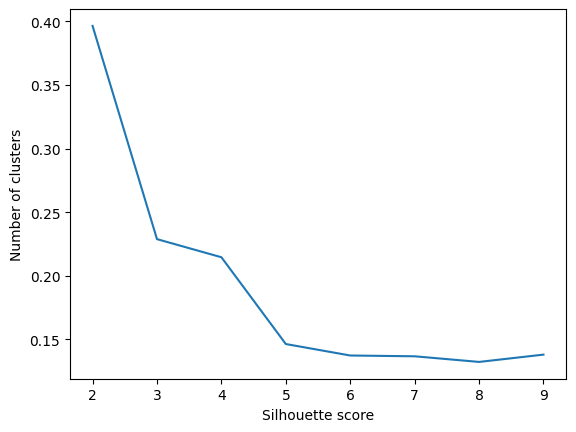

In [15]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

n_clusters_list = np.arange(2,10)
sil_scores = [] # where we'll save the scores
labels_list = [] # where we'll save the labels

for n_clusters in n_clusters_list:
    km = KMeans(n_clusters = n_clusters)
    labels = km.fit_predict(distances)
    score = silhouette_score(distances, labels)

    sil_scores.append(score)
    labels_list.append(labels)

plt.figure()
plt.xlabel("Silhouette score")
plt.ylabel("Number of clusters")
plt.plot(n_clusters_list, sil_scores)

In our case, n_clusters = 2 seems to be the "best" one. Note that the notion of "best" clusters is vague and highly dependent on the specific application. In most cases, knowledge of the system at hand should be applied to determine the clustering quality.

We can now analyse our clusters: since the dataset provided energies as well as geometric information, we can see if the energy distribution varies from one cluster to the other.

(Note: we will continue with 2 clusters, as indicated by the silhouette score, but the code below is written generally. Change the variable n_clusters to switch to a higher number.)

Text(0.5, 0, 'Energy [kcal/mol]')

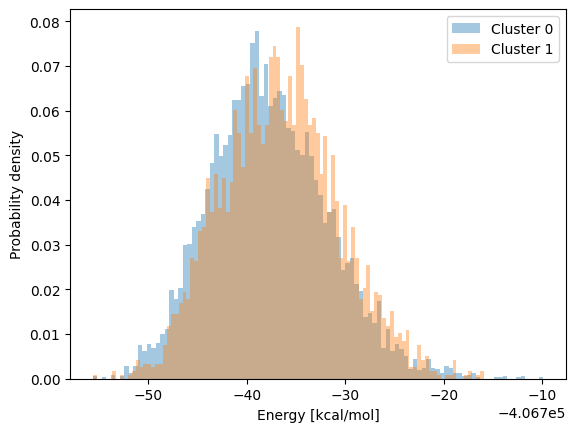

In [55]:
n_clusters = 2
labels = labels_list[n_clusters-2]

# For each cluster, create an energy subset and plot the distribution
plt.figure()
for i in range(n_clusters):
    cluster_idxs = np.argwhere(labels == i).flatten()
    ei = E[cluster_idxs]
    plt.hist(ei, bins = 100, alpha = 0.4, density = True, label = f'Cluster {i}')
plt.legend()
plt.ylabel("Probability density")
plt.xlabel("Energy [kcal/mol]")


Overall, there is a very slight shift in energy distribution from cluster to cluster. However, the cluster label of a point is not a strong indicator for its energy: this makes sense, as predicting the potential energy surface from the geometry of a molecule is a highly complex task for which significantly more elaborate (and supervised) methods are required.

That being said, the two clusters have in fact split the dataset into meaningfully different parts: to prove this, we will look at the dihedral angle between the benzene ring and the carboxylic group attached to it. This is one of the major ways this molecule can rotate and it takes up various values throughout the reference trajectory.

In [56]:
from ase.visualize import view

# indices of atom1,2,3,4 forming the aforementioned dihedral
#   
dihedral_indices = [6,5,10,7]
view(atoms[0], viewer='x3d')

Text(0, 0.5, 'Prob. density')

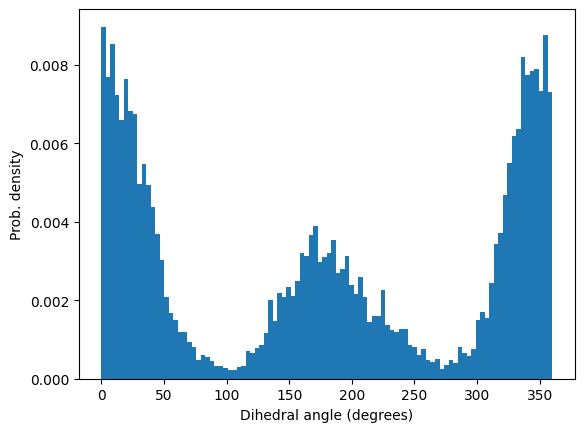

In [57]:
dihedrals = np.array([x.get_dihedral(*dihedral_indices) for x in atoms])

plt.figure()
plt.hist(dihedrals, bins = 100, density = True)
plt.xlabel("Dihedral angle (degrees)")
plt.ylabel("Prob. density")



Throughout the entire trajectory, the dihedral angle spends most of its time around 360 and 180 degrees, as indicated by the well-defined peaks above. We can now plot the same dihedral angle but for each cluster seperately.

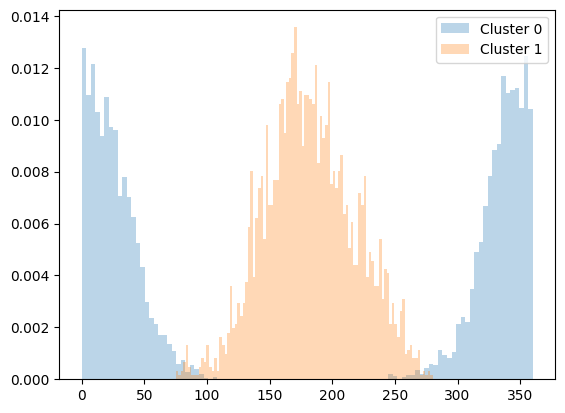

In [58]:
# For each cluster, create a dihedral subset and plot the distribution
plt.figure()
for i in range(n_clusters):
    cluster_idxs = np.argwhere(labels == i).flatten()
    dih = dihedrals[cluster_idxs]
    plt.hist(dih, bins = 100, alpha = 0.3, density = True, label = f'Cluster {i}')

plt.legend()

With 2 clusters, we see a very good separation between the two dihedral peaks for each cluster. That is, this clearly shows that different clusters do represent qualitatively different geometries. For a higher number of clusters, there is a greater overlap for this particular dihedral (however, other geometrical properties not shown here would be different). 